In [1]:
from astropy.io import fits
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.wcs import WCS
import cv2
import scipy.ndimage
from glob import glob
from astropy.convolution import convolve_fft

In [12]:
# Coordinate Transforms
def to_world(fname,pix_x,pix_y):
    return WCS(fname).all_pix2world(pix_x,pix_y,0)
def to_pix(fname,ra,dec):
    return WCS(fname).all_world2pix(ra,dec,0)

# Kernel Adjustments
def check_kernel(kernel_fname):
    if type(kernel_fname) is str:
        kernel = fits.open(kernel_fname)[0].data
    else:
        kernel = kernel_fname
    # Square
    if kernel.shape[0] != kernel.shape[1]:
        print("Additional Code Required. Square the Kernel.")
    # Max in Center
    ind = np.unravel_index(np.argmax(kernel),np.shape(kernel))    
    if ind[0] != ind[1] and np.abs(ind[0] / kernel.shape[0] - 0.5) > 0.002:
        print("Additional Code Required. Max value not centered.")
        print(np.abs(ind[0] / kernel.shape[0] - 0.5))
    # Normalize
    if np.nansum(kernel) != 1:
        kernel = kernel / np.nansum(kernel) 
    return kernel

# Reduce Mask 
def mask_reduction(x,y):
    # Create mask arrays. 
    maskx_x, maskx_y = [],[]
    for i in range(np.max(x)): 
        # remove duplicates in X          
        look = np.where(x == i)[0]
        dim = np.shape(look)
        if dim[0] > 0: 
             maskx_y.append(y[look[0]])
             maskx_y.append(y[look[len(look)-1]])
             maskx_x.append(x[look[0]])
             maskx_x.append(x[look[len(look)-1]])

    masky_x, masky_y = [],[]
    for i in range(np.max(y)):  
        # remove duplicates in Y
        look = np.where(y == i)[0]
        dim = np.shape(look)
        if dim[0] > 0: 
             masky_y.append(y[look[0]])
             masky_y.append(y[look[len(look)-1]])
             masky_x.append(x[look[0]])
             masky_x.append(x[look[len(look)-1]])

    mask_x = maskx_x + masky_x         
    mask_y = maskx_y + masky_y

    return np.asarray(list(zip(mask_x,mask_y)))

# Diffusion
def ApplyBoundaryConditions(original_data, new_data, index_set, timestep) :
    for indexPair in index_set :
        # Converts between index in original image and index in smaller template img. 
        # Diffusion occurs in smaller template image and then gets replaced in the 
        i = int(indexPair[1]) - minY
        j = int(indexPair[0]) - minX
        new_data[i,j,timestep] = original_data[int(indexPair[1]), int(indexPair[0])]
def StepForward(data, timestep) :
    xLim, yLim, junk = np.shape(data)
    # Kappa should be small to avoid converging too quicly, 
    # but is arbitrary as we are using the 
    # homoginzed solution as a final stopping place. 
    alpha = 0.1
    for i in range(1, xLim-1) :
        for j in range(1, yLim-1) :
            # Discretizing heat equation
            # Backward Finite Difference in Time
            # Second Order Central Difference in Space
            data[i,j,timestep] = data[i,j,timestep-1] + alpha * (
                    (data[i+1,j,timestep-1] - 2*data[i,j,timestep-1] +
                    data[i-1,j,timestep-1]) + (data[i,j+1,timestep-1] -
                        2*data[i,j,timestep-1] + data[i,j-1,timestep-1]
                            ))        
def InsideSet(index_array, i, j) :
    sameJ = np.where(np.isclose(index_array[:, 1], j))[0]
    sameI = np.where(np.isclose(index_array[:, 0], i))[0]
    if len(sameJ) == 0 or len(sameI) == 0 :
        return False
    possibleIs = index_array[sameJ][:,0]
    possibleJs = index_array[sameI][:,1]
    minI = min(possibleIs)
    minJ = min(possibleJs)
    maxI = max(possibleIs)
    maxJ = max(possibleJs)
    if minI <= i and i <= maxI and minJ <= j and j <= maxJ :
        return True
    return False

kernel_file = glob("Convolve_Regrid/Kernels/*.fits") 

## Spitzer and Herschel Infrared Images at 24, 70, 100 and 160 microns.

In [3]:
infrared_file = ["Original_Files/Infrared/" + file for file in ["n76crop_smcsage_24.fits","e0102_pacs70_new.fits","e0102_pacs100_new.fits","e0102_pacs160_new.fits"]]

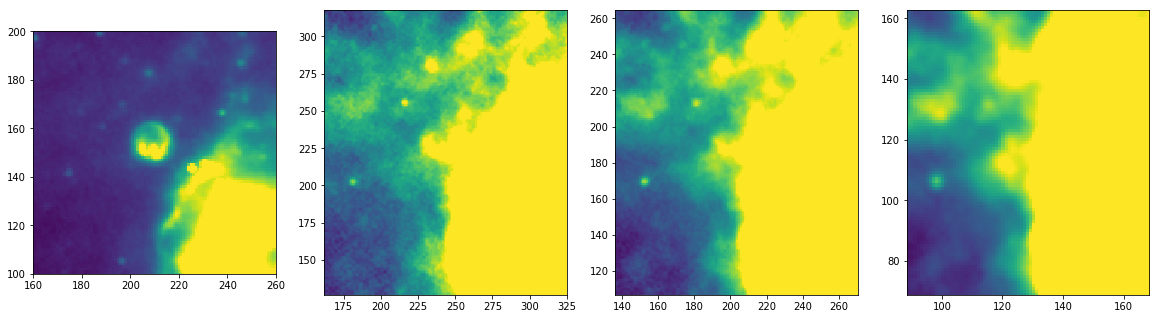

In [4]:
# Set plot dimensions by first image and transform coordinates to the other images
xdim = [160,260]
ydim = [100,200]
ra,dec = to_world(infrared_file[0],xdim,ydim)
dim = np.array([to_pix(file,ra,dec) for file in infrared_file])

# Get a region to sample the min,max of the image.
d = [fits.open(file)[0].data[int(dim[i,0,0]):int(dim[i,0,1]),int(dim[i,1,0]):int(dim[i,1,1])] for i,file in enumerate(infrared_file)]

f, axes = plt.subplots(1,4,figsize=(20,10))
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(to_pix(file,ra,dec)[0]) for i,file in enumerate(infrared_file)]
[axes[i].set_ylim(to_pix(file,ra,dec)[1]) for i,file in enumerate(infrared_file)];

## Create Mask from Convolved Xray File

In [13]:
xray_file = 'Original_Files/Xray/e0102_1100-2000eV.fits'
xray_kernel_files = [kernel_file[i] for i in [1,4,2,3]]
xray_kernels = [check_kernel(kernel) for kernel in xray_kernel_files]

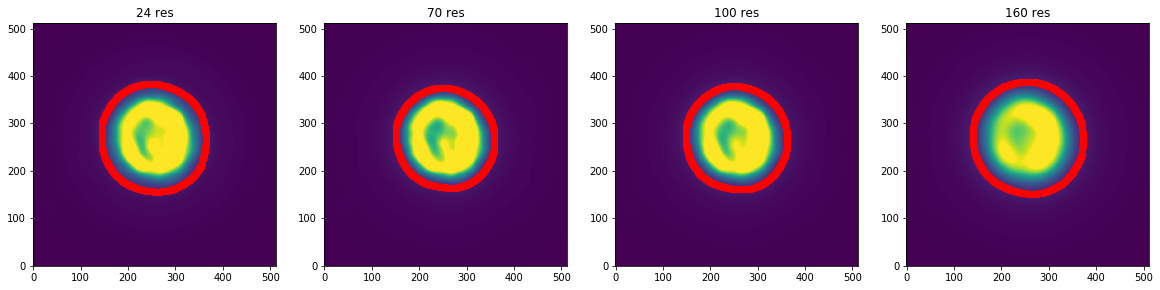

In [14]:
# Middle two rows should be zero or there may be some rotation. 
xray_kernel_scales = np.array([fits.open(file)[0].header[key] for file in xray_kernel_files for key in  ['CD1_1','CD1_2','CD2_1','CD2_2'] ])

# The absolute value of CDELT1 and CDELT2 should be equal. 
xray_image_scale = np.abs(fits.open(xray_file)[0].header['CDELT1'])

# Scaling is xray image / kernel
xray_scale = xray_image_scale / xray_kernel_scales[0]

# Invert scaling to regrid
new_kernels = [check_kernel(scipy.ndimage.zoom(kernel, 1/xray_scale, order = 1)) for kernel in xray_kernels]

# Convolve
convolved_xray = [convolve_fft(fits.open(xray_file)[0].data,kernel,allow_huge=True) for kernel in new_kernels ]

# Detect Edges 
edges = [cv2.Canny(np.uint8(convolution),0,5) for convolution in convolved_xray]

# Get Edge Coordinates
ys,xs = [np.array(np.where(edge == 255) )[0] for edge in edges], [np.array(np.where(edge == 255) )[1] for edge in edges]

# Reduce Coordinates
masks = [mask_reduction(x,y) for x,y in zip(xs,ys)]

# Convolved Xray Image with Mask
f, axes = plt.subplots(1,4,figsize=(20,10))
[axes[i].imshow(file, origin='lower',vmin=0,vmax=10) for i,file in enumerate(convolved_xray)]
[axes[i].set_title(title) for i,title in enumerate(['24 res','70 res','100 res','160 res'])];
[axes[i].scatter(masks[i][:,0],masks[i][:,1],c='r') for i in range(4)];

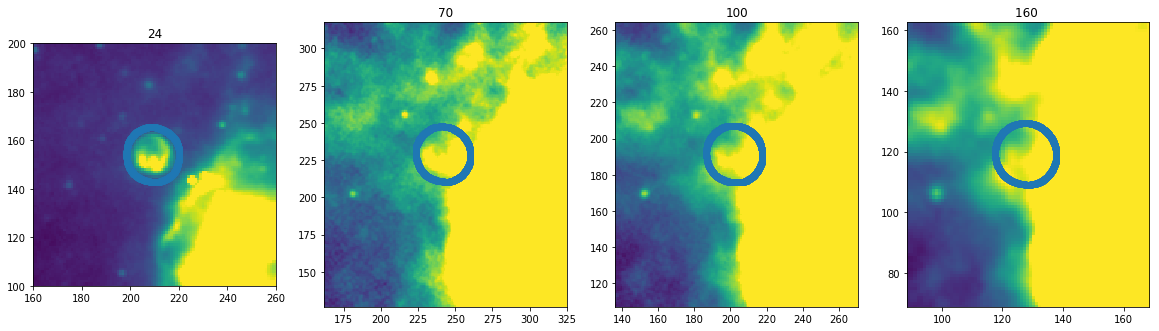

In [15]:
# Transform Mask Coordinates to Appropriate Infrared Image
mask_wcs = [to_world(xray_file,masks[i][:,0],masks[i][:,1]) for i in range(4)]
mask_pix = np.array([to_pix(infrared_file[i],np.array(mask_wcs[i])[0,:],np.array(mask_wcs[i])[1,:]) for i in range(4)])

# Infrared Mask Coordinates
f, axes = plt.subplots(1,4,figsize=(20,10))
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(to_pix(file,ra,dec)[0]) for i,file in enumerate(infrared_file)]
[axes[i].set_ylim(to_pix(file,ra,dec)[1]) for i,file in enumerate(infrared_file)];
[axes[i].scatter(mask_pix[i][0],mask_pix[i][1]) for i,file in enumerate(infrared_file)];
[axes[i].set_title(title) for i,title in enumerate(['24','70','100','160 '])];

## Background Removal

In [ ]:
# We know this region is easily oversubtracted. It's the lowest point in the supernova. 
# The background removal shouldn't make this region negative if it's done right. 
null_ra,null_dec = np.loadtxt("Background_Removal/Bootstrap/NullRegionCoordinates.txt")
null_coords =  np.array([to_pix(infrared_file[i],null_ra,null_dec) for i in range(4)])

# Low Emission Region
f, axes = plt.subplots(1,4,figsize=(20,10))
n=10
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(np.min(null_coords[i][0,:])-n,np.max(null_coords[i][0,:])+n) for i in range(4)]
[axes[i].set_ylim(np.min(null_coords[i][1,:])-n,np.max(null_coords[i][1,:])+n) for i in range(4)]
[axes[i].scatter(null_coords[i][0,:],null_coords[i][1,:]) for i in range(4)];
[axes[i].set_title(title) for i,title in enumerate(['24','70','100','160 '])];

In [ ]:
def diffusion_inpainting(x,y,data):
    global minY, minX
        
    minX = int(min(x))
    maxX = int(max(x)+1)
    minY = int(min(y))
    maxY = int(max(y)+1)
        
    xyZip = list(zip(x,y))
    xyArray = np.asarray(xyZip)

    saveEveryXFrames = 5
    maxNumberOfSteps = 10000

    saveCounter = 0
    intensity_values = np.zeros([maxY-minY, maxX-minX, maxNumberOfSteps])
    # Fill in the mask coordinates with their original intensity values. 
    ApplyBoundaryConditions(data, intensity_values, xyZip, 0);
    
    subs, shells = [],[]
    for t in range(1,maxNumberOfSteps+1):
        # Do Diffusion Step
        StepForward(intensity_values, t);
        # Re-plug in the mask intensitity values.
        ApplyBoundaryConditions(data, intensity_values, xyZip, t);

        shell = np.copy(data)
        for i in range(shell.shape[0]):
            for j in range(shell.shape[1]):
                if InsideSet(xyArray, i, j) :
                    shell[j,i] = intensity_values[j-minY, i-minX, t]

        # Remove the background (shell) from the original image.
        subs.append(np.copy(data) - np.copy(shell))
        shells.append(sub)
    
    return subs, shells

sub, shell = diffusion_inpainting(mask_pix[0][0],mask_pix[0][1],fits.open(infrared_file[0])[0].data)

In [ ]:
xyZip = list(zip(mask_pix[0][0],mask_pix[0][1]))
xyArray = np.asarray(xyZip)
data = fits.open(infrared_file[0])[0].data
np.where([InsideSet(xyArray, i,j) for i in np.arange(data.shape[0]) for j in np.arange(data.shape[1])])

In [ ]:
xyArray.shape

In [ ]:
plt.scatter(xyArray[:,0],xyArray[:,1])

In [ ]:
gifname = "Diffuse24"
# Set up the animation
vmin,vmax = 0, 10

f, axes = plt.subplots(1,2,figsize=(10,10))
im = [[axes[0].imshow(sub, vmin = vmin, vmax = vmax, animated=True, origin="lower"),
       axes[1].imshow(shell, vmin = vmin, vmax = vmax, animated=True, origin="lower")
       for i,file in enumerate(exclude_null_filenames)]

plt.tight_layout()


# Write the animation out 
writer=animation.ImageMagickWriter(fps=5)
movie = animation.ArtistAnimation(fig, im,interval=1000, blit=True,repeat_delay=1000)

# To Display online the gif needs to be in the same folder as the notebook for some reason.
movie.save('%s.gif' % gifname,writer=writer)
plt.close()

# Play the animation
Markdown("![Movie](%s.gif)" % outdir)